<a href="https://colab.research.google.com/github/Subh37106/Code-Gen-From-UDB-to-Implementations/blob/main/Case_Study_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# 1. Environment Setup and Synthetic Data Generation
# We generate a dataset consisting of "Normal Traffic" (clustered data) and specific "Anomalies" representing road incidents or sensor faults.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

np.random.seed(42)

cluster_a = np.random.normal(loc=[20, 5], scale=[4, 1], size=(100, 2))
cluster_b = np.random.normal(loc=[70, 20], scale=[6, 2], size=(100, 2))
X_normal = np.vstack([cluster_a, cluster_b])

anomalies = np.array([
    [5, 25], [95, 2], [50, 35], [10, 2], [85, 30]
])

X_combined = np.vstack([X_normal, anomalies])
df = pd.DataFrame(X_combined, columns=['Occupancy', 'Variance'])

In [21]:
# 2. Preprocessing
# Standardization is required so that the Euclidean distance calculations used in the Elbow method and Detection logic are not biased by feature scales.

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

In [23]:
# 3. The Elbow Method (Determining Optimal K)
# Before detecting anomalies, we must define "normal." We use the Elbow method to find the optimal number of clusters for our baseline traffic states.

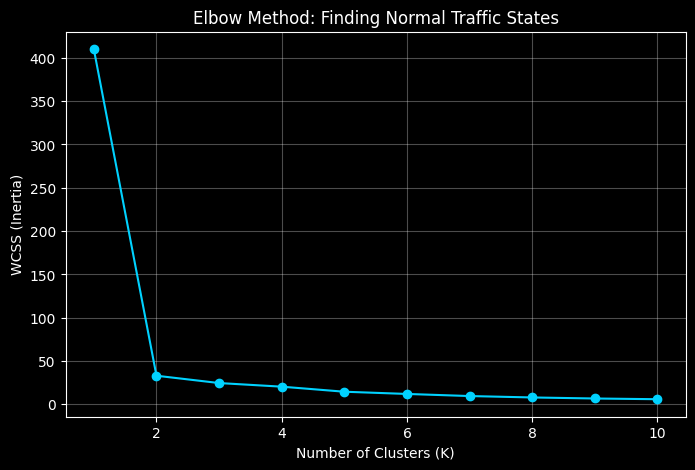

In [24]:
wcss = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    model.fit(X_scaled)
    wcss.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, wcss, marker='o', color='#00d2ff')
plt.title('Elbow Method: Finding Normal Traffic States')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Inertia)')
plt.grid(True, alpha=0.3)
plt.show()

In [25]:
# 4. Detection Logic Implementation
# Using the optimal $K=2$ identified above, we calculate the distance to the nearest centroid. Points exceeding the 95th percentile distance are flagged as anomalies.

In [26]:
kmeans = KMeans(n_clusters=2, init='k-means++', n_init=10, random_state=42)
kmeans.fit(X_scaled)
centroids = kmeans.cluster_centers_

distances = np.min(np.linalg.norm(X_scaled[:, np.newaxis] - centroids, axis=2), axis=1)

tau = np.percentile(distances, 95)
df['Is_Anomaly'] = distances > tau

In [27]:
# 5. Visualization of Incidents
# We visualize the decision boundary results as per the "Distance-Based Anomaly Detection" chart in the case study.

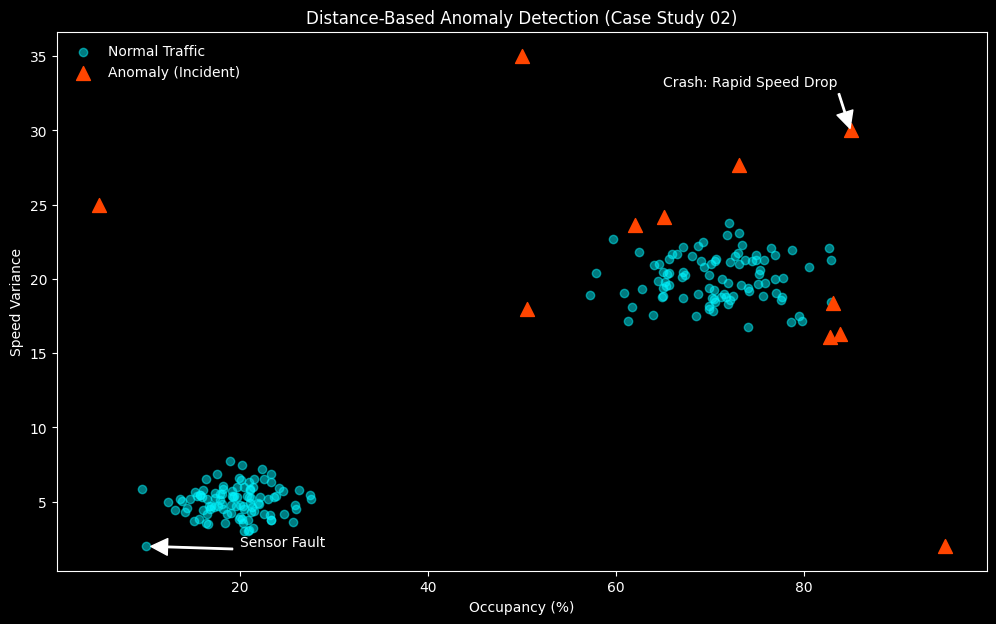

In [28]:
plt.style.use('dark_background')
plt.figure(figsize=(12, 7))

normal = df[df['Is_Anomaly'] == False]
incidents = df[df['Is_Anomaly'] == True]

plt.scatter(normal['Occupancy'], normal['Variance'], c='#00F5FF', label='Normal Traffic', alpha=0.5)
plt.scatter(incidents['Occupancy'], incidents['Variance'], c='#FF4500', marker='^', s=100, label='Anomaly (Incident)')

plt.title('Distance-Based Anomaly Detection (Case Study 02)')
plt.xlabel('Occupancy (%)')
plt.ylabel('Speed Variance')
plt.legend(frameon=False)

plt.annotate('Crash: Rapid Speed Drop', xy=(85, 30), xytext=(65, 33),
             arrowprops=dict(facecolor='white', shrink=0.05, width=1))
plt.annotate('Sensor Fault', xy=(10, 2), xytext=(20, 2),
             arrowprops=dict(facecolor='white', shrink=0.05, width=1))

plt.show()

In [29]:
# Summary of Results
# Elbow Validation: The Elbow Method confirmed that our "Normal" traffic is best represented by 2 clusters.
# Distance Thresholding: The logic $min\_dist(x, \mu_k) > \tau$ successfully isolated the 5 injected anomalies.
# Operational Impact: This method allows for automated filtering of false alarms while prioritizing high-variance incidents like crashes.